# Downloading and setting up Lag-llama

In [ ]:
# !git clone https://github.com/time-series-foundation-models/lag-llama/

In [2]:
# cd lag-llama

c:\Users\topco\Dokumenti\MSc Banking and Digital Finance UCL\Modules\Dissertation\MSc_dissertation\lag-llama


In [3]:
# !pip install -r requirements.txt --quiet 

In [6]:
# !huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir lag-llama


lag-llama\lag-llama.ckpt


# Importing libraries

In [7]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

C:\Users\topco\AppData\Roaming\Python\Python311\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


# lag llama predict function

In [8]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

# Data collection and preprocessing

In [9]:
import yfinance as yf
from datetime import datetime, timedelta

In [50]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "NVDA"]

end_date = datetime.today()
start_date = end_date - timedelta(days=365)  
data = yf.download(tickers, start=start_date, end=end_date, interval="1d")["Adj Close"]
stock_prices = pd.DataFrame(data)
stock_prices.index.name = None


[*********************100%%**********************]  7 of 7 completed


## Preprocessing

In [51]:
for col in stock_prices.columns:
    # Check if column is not of string type
    if stock_prices[col].dtype != 'object' and pd.api.types.is_string_dtype(stock_prices[col]) == False:
        stock_prices[col] = stock_prices[col].astype('float32')

full_date_range = pd.date_range(start=stock_prices.index.min(), end=stock_prices.index.max(), freq='D')
stock_prices = stock_prices.reindex(full_date_range)
stock_prices.ffill(inplace=True)

# Create a PandasDataset
#freq = "B" # B is for business days
#ds = PandasDataset(dataframes=dict(stock_prices), freq=freq)
ds = PandasDataset(dict(stock_prices))

backtest_dataset = ds
prediction_length = 10  # Define your prediction length 
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cpu") # You can switch this to CPU or other GPUs if you'd like, depending on your environment # modified by FILIP

In [49]:
ds

PandasDataset<size=7, freq=B, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [52]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)

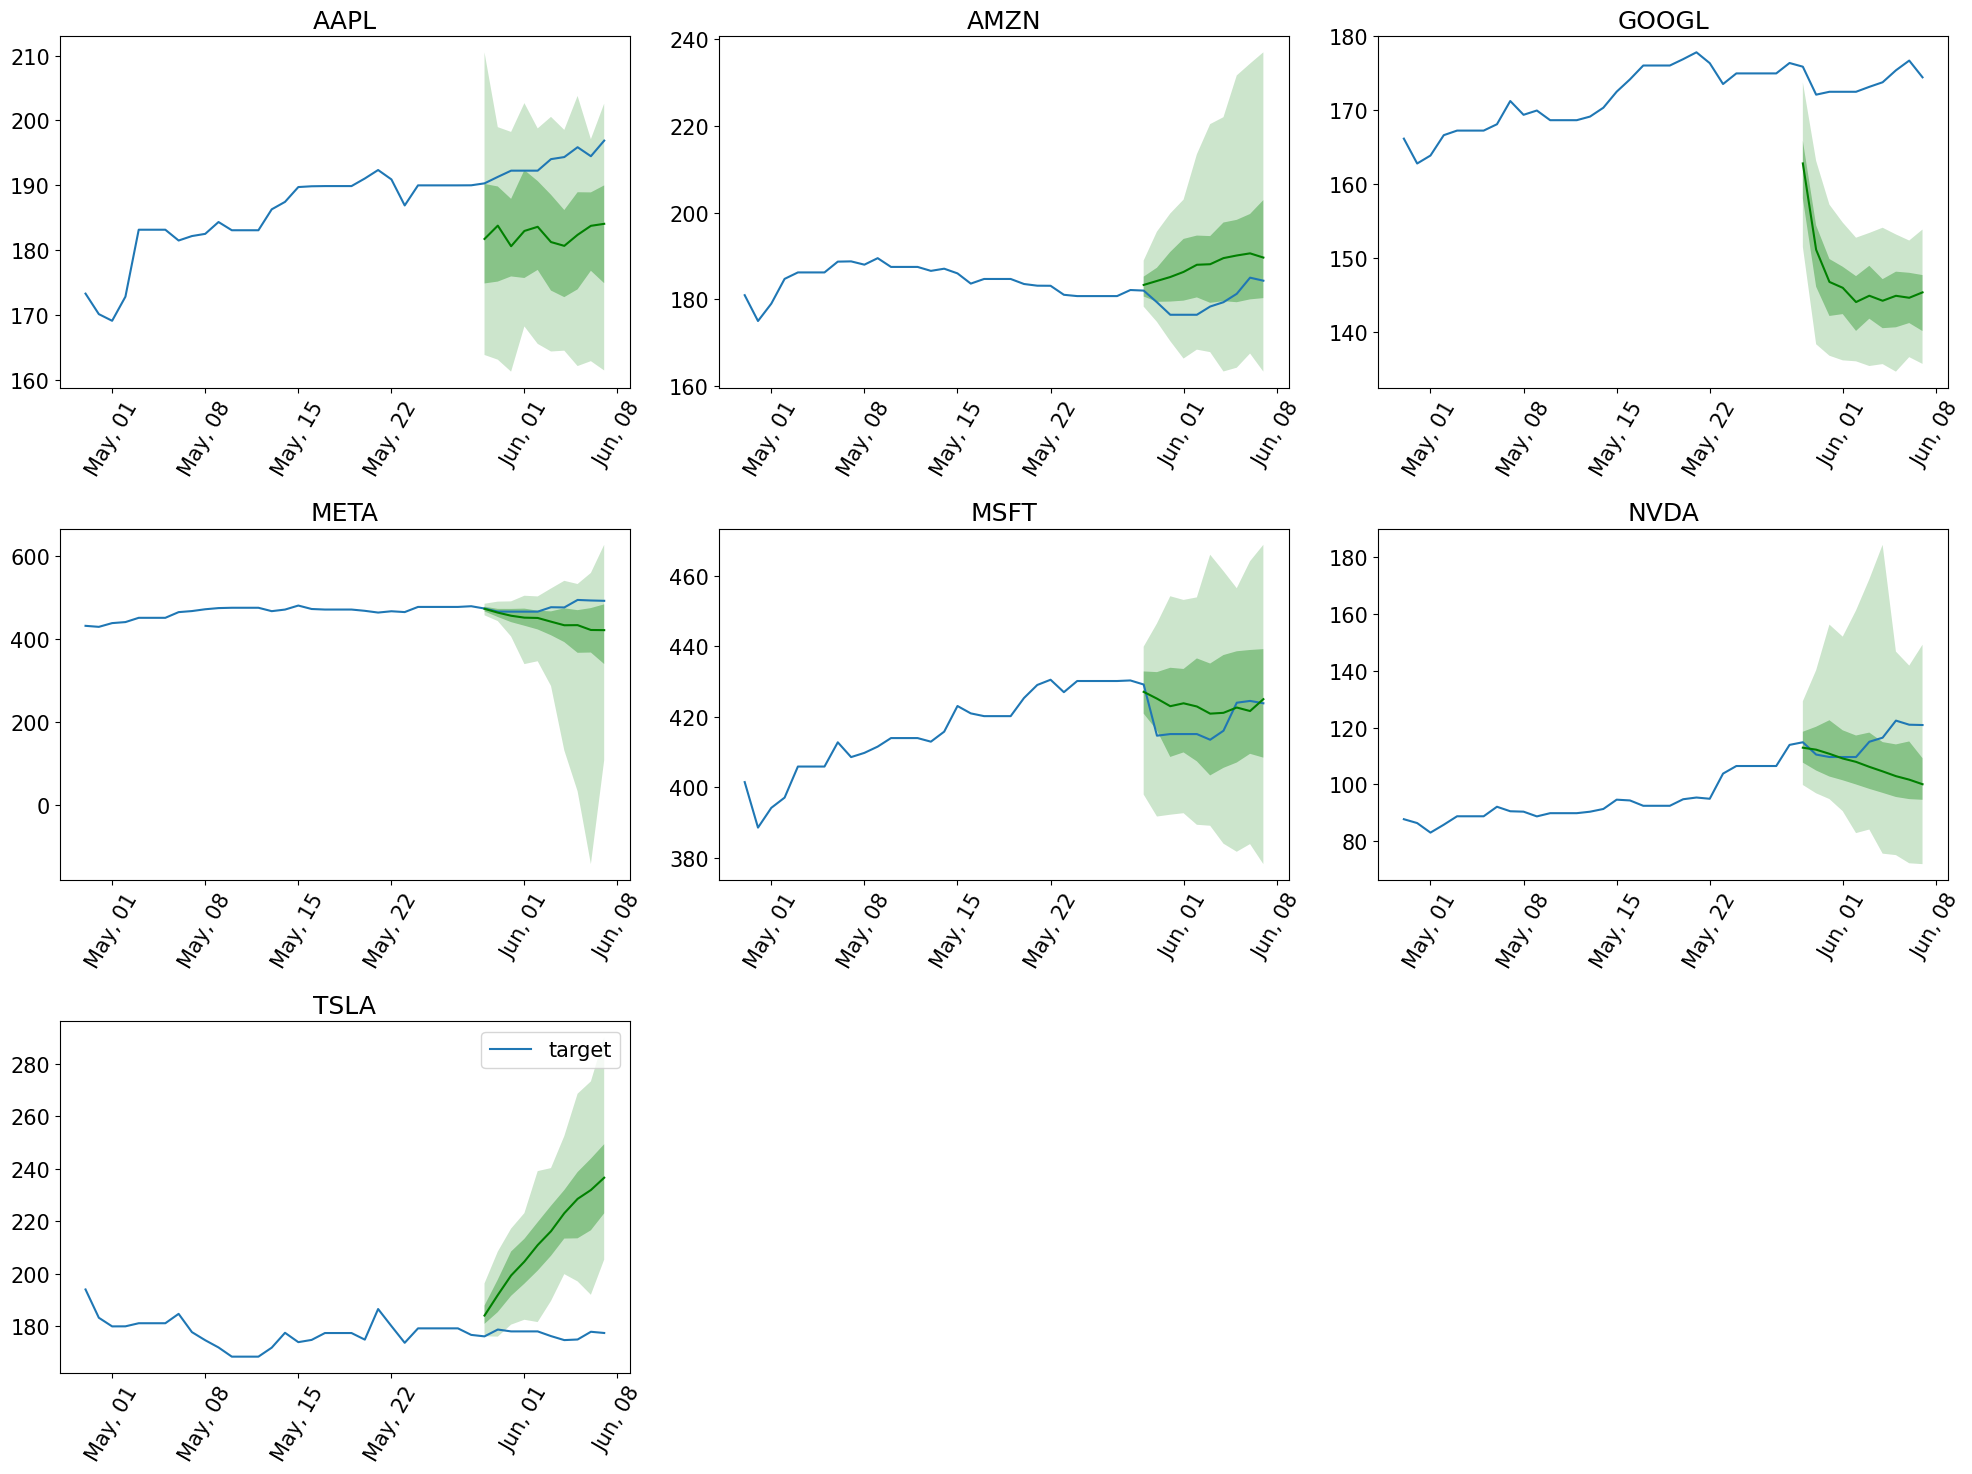

In [54]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [55]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, context_length=64, use_rope_scaling=False, num_samples=30)

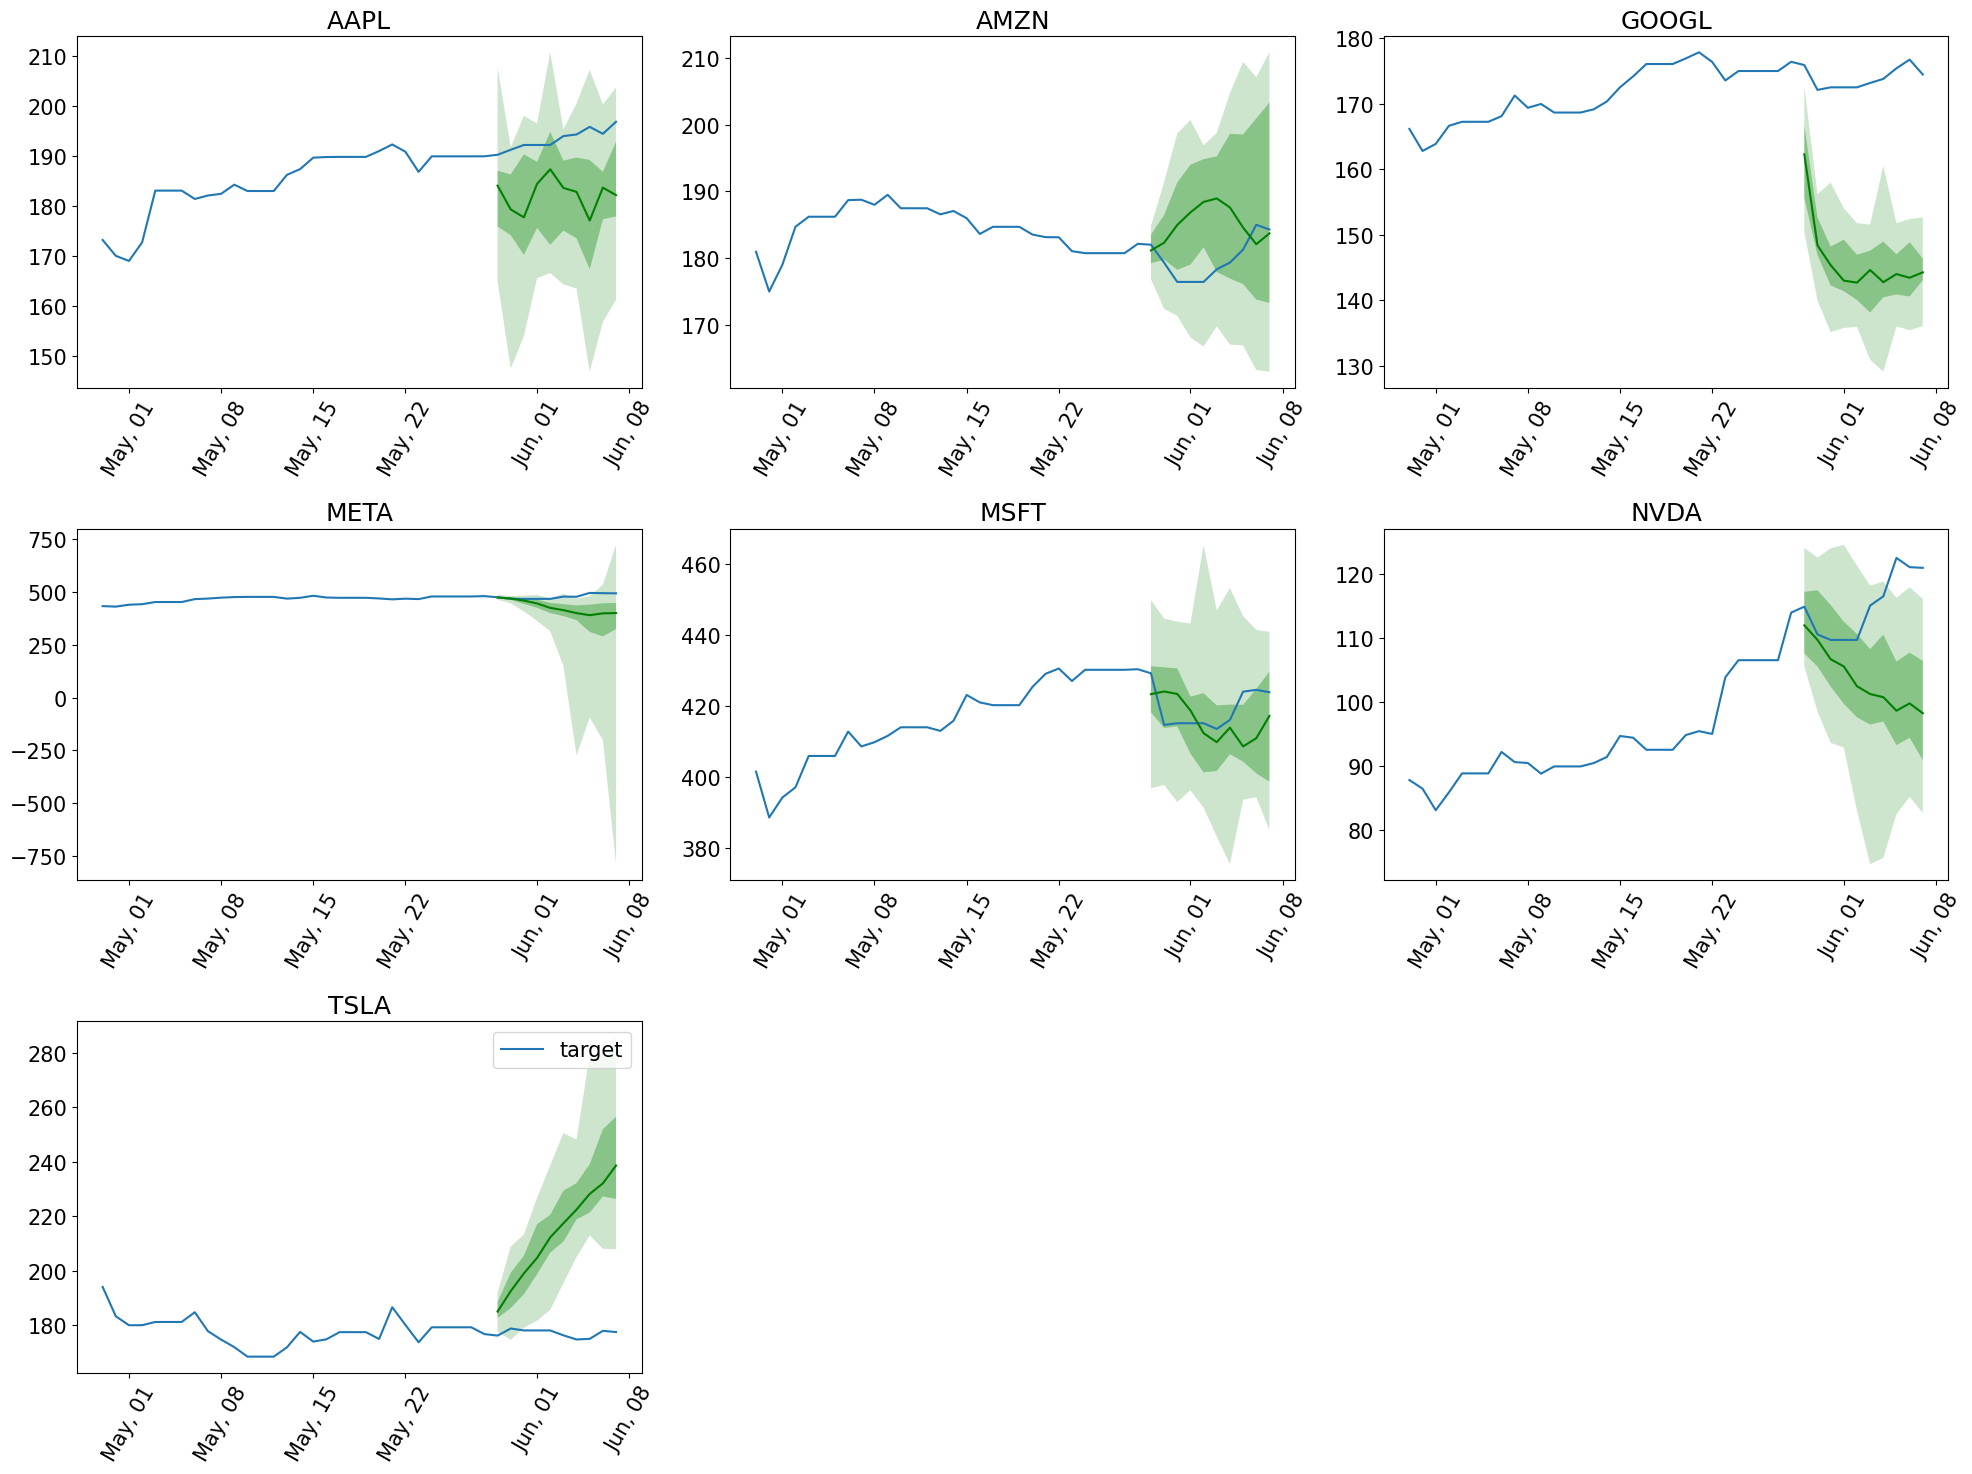

In [56]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [57]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, context_length=128, use_rope_scaling=False, num_samples=30)

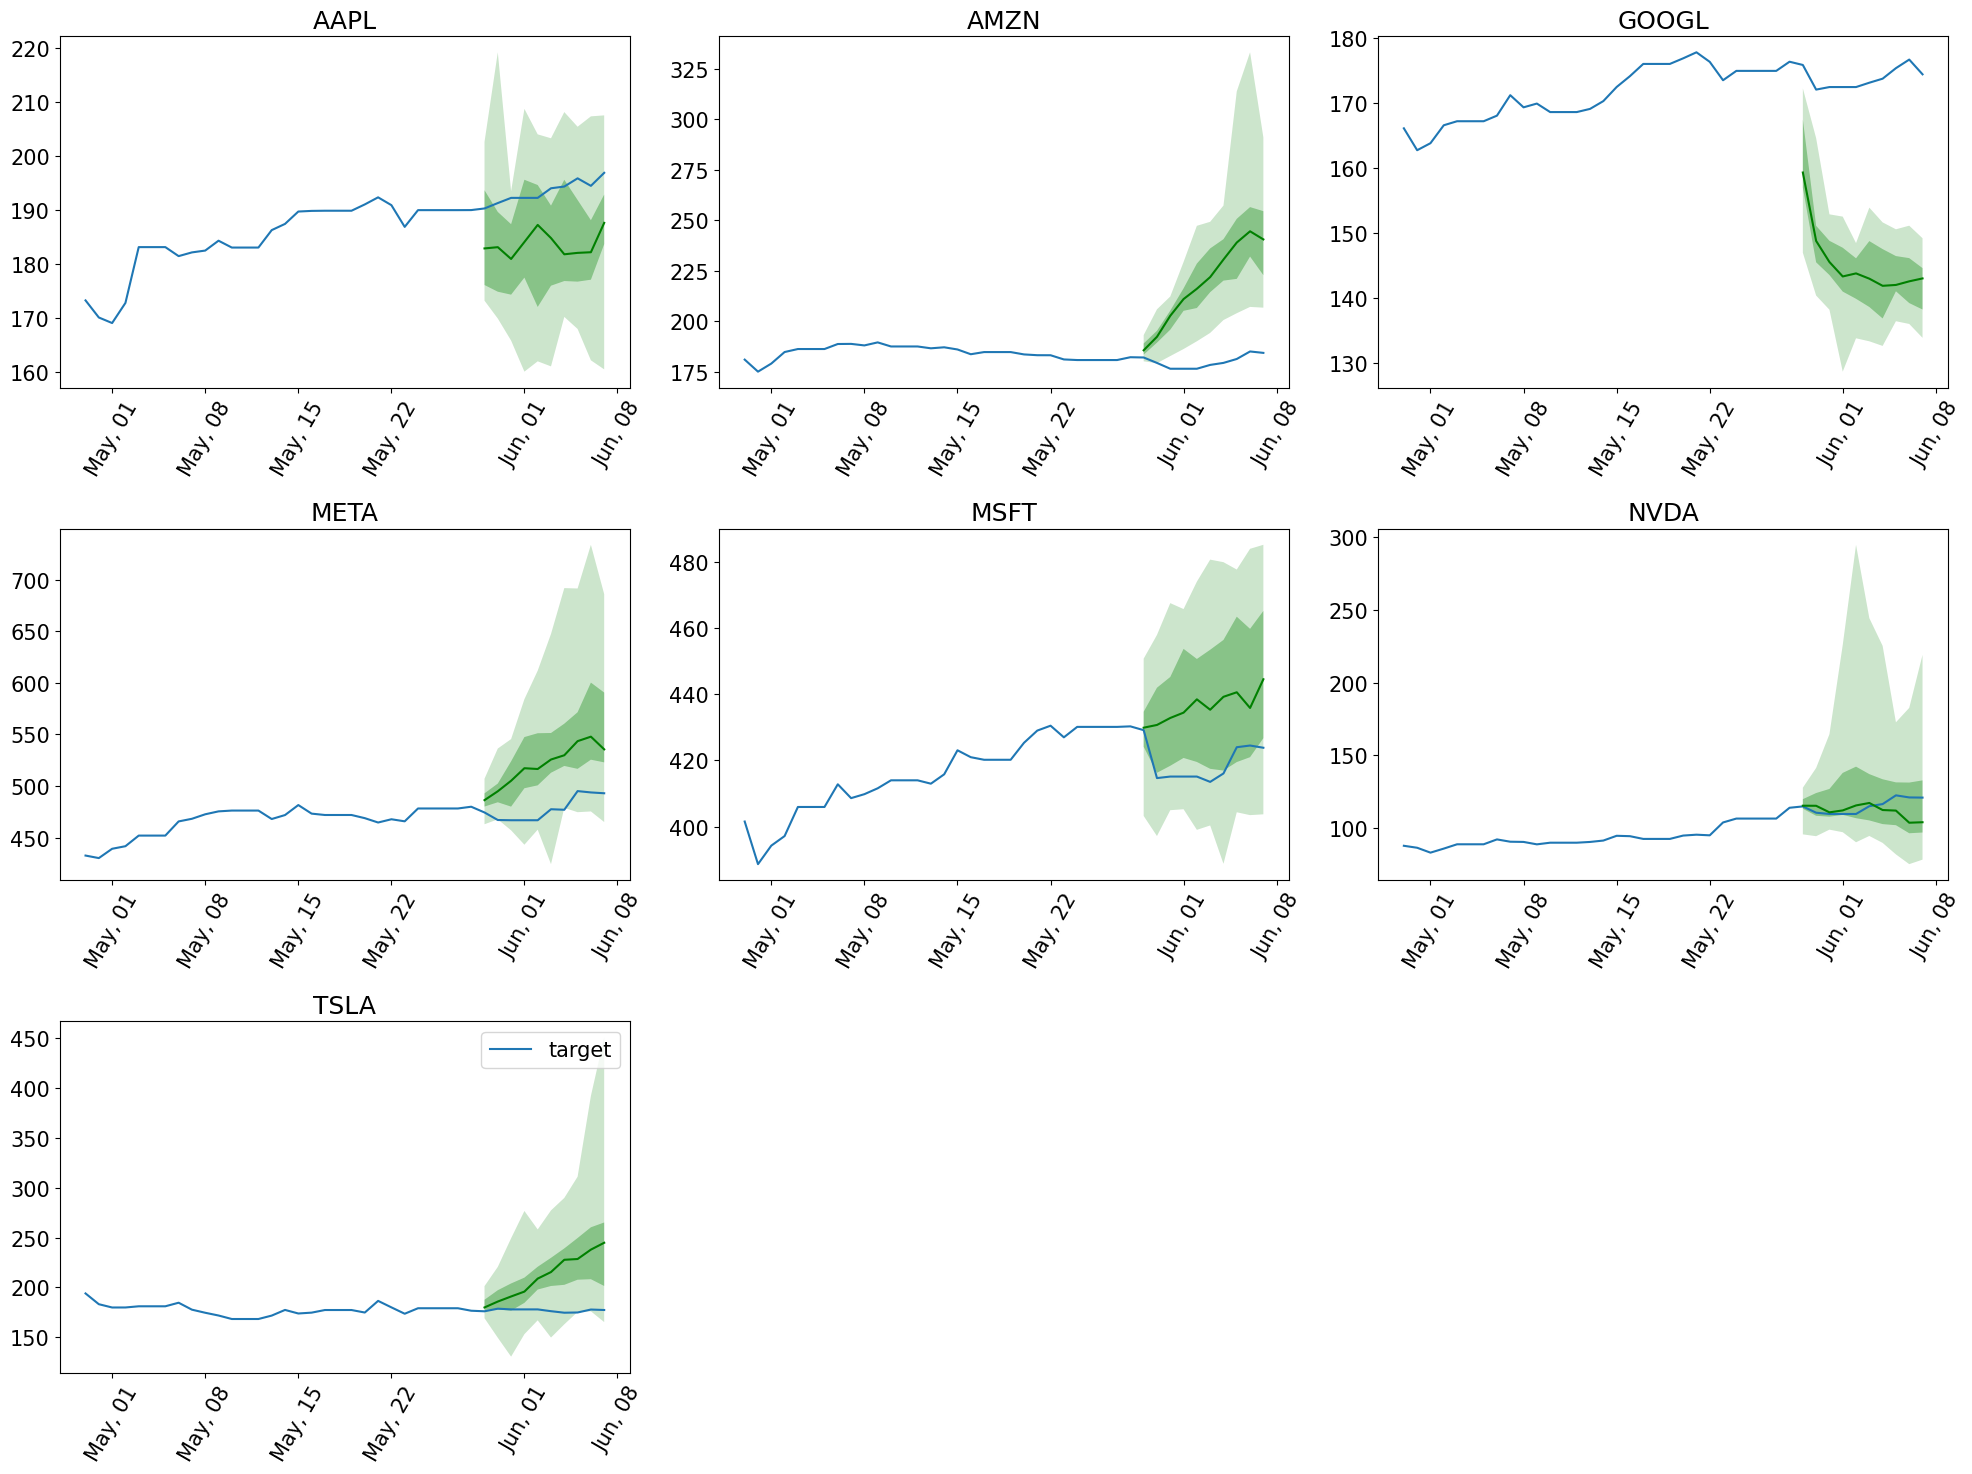

In [58]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()